In [1]:
import pandas as pd
import numpy as np
import pyranges as pr
import os
import sys
from collections import Counter
import gget
import scipy
import scanpy as sc
from kneed import KneeLocator
import sklearn.metrics
import sklearn.preprocessing as skprep

import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from importlib import reload

"""WARNING: disabling future warnings"""
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sys.path.append("../")
import utils as ut
reload(ut)

<module 'utils' from '/home/cstansbu/git_repositories/ONT-single-cell/notebooks/utils.py'>

In [3]:
fpath = "/nfs/turbo/umms-indikar/shared/projects/HSC/data/results/HSC/scanpy/anndata.tabula.h5ad"

adata = sc.read_h5ad(fpath)
adata

AnnData object with n_obs × n_vars = 35830 × 14599
    obs: 'cluster_name', 'set', 'UMAP 1', 'UMAP 2', 'organ_tissue', 'celltype'
    var: 'gene_id', 'gene_symbol', 'is_fb_marker', 'is_hsc_marker'
    uns: 'log1p'
    layers: 'combat_corrected', 'log_tpm', 'raw_counts'

Text(0.5, 1.0, 'iHSC Data')

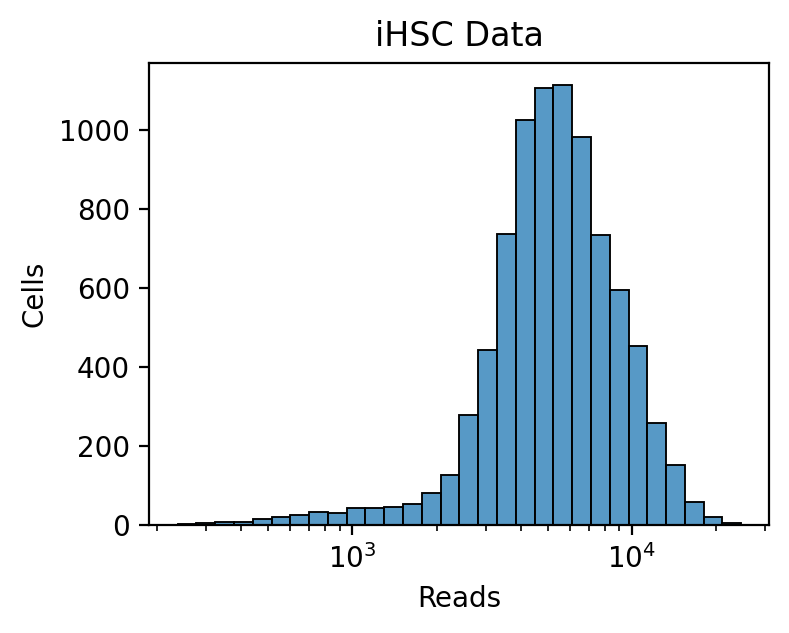

In [13]:
counts = adata[adata.obs['set'] == 'our_data', :].to_df(layer='raw_counts')
sum_counts = counts.sum(axis=1)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 3
sns.histplot(data=sum_counts,
             bins=30,
             log_scale=True)

plt.ylabel("Cells")
plt.xlabel("Reads")
plt.title('iHSC Data')

Text(0.5, 1.0, 'Tabula Sapiens Data')

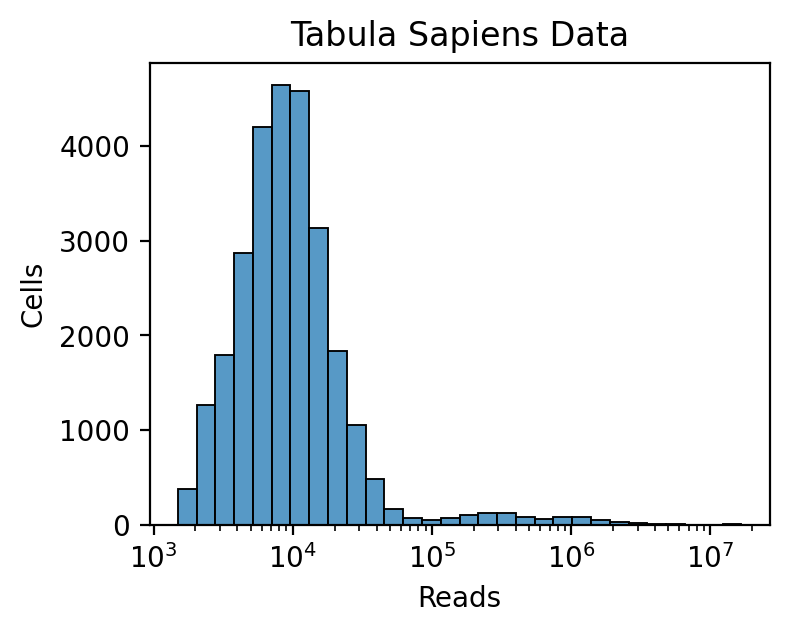

In [16]:
counts = adata[adata.obs['set'] == 'ref_data', :].to_df(layer='raw_counts')
sum_counts = counts.sum(axis=1)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 3
sns.histplot(data=sum_counts,
             bins=30,
             log_scale=True)

plt.ylabel("Cells")
plt.xlabel("Reads")
plt.title('Tabula Sapiens Data')

In [ ]:
break

In [ ]:
id2name = dict(zip(adata.var.index.values, adata.var['gene_name'].values))
name2id = dict(zip(adata.var['gene_name'].values, adata.var.index.values))
print('done')

In [ ]:
pdf = adata.obs.copy()
pdf['UMAP 1'] = adata.obsm['X_umap'][:, 0]
pdf['UMAP 2'] = adata.obsm['X_umap'][:, 1]

colors = ['darkgreen', 'red', "orange", "limegreen"]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4
sns.scatterplot(data=pdf,
                x='UMAP 1',
                y='UMAP 2',
                hue='cluster_name',
                palette=colors,
                s=8,
                alpha=0.85,
                legend=False,
                ec='none'
        )

sns.despine()
plt.xticks([])
plt.yticks([])

# Read Depth

In [ ]:
print(f"{adata.obs['total_counts'].mean()=}")
print(f"{adata.obs['total_counts'].median()=}")
sns.histplot(x=adata.obs['total_counts'], 
             bins=31)

plt.xlabel('Read Count')
plt.xlabel('Cell Count')
sns.despine()


In [ ]:
adata

In [ ]:
print(f"{adata.obs['n_genes'].mean()=}")
print(f"{adata.obs['n_genes'].median()=}")
sns.histplot(x=adata.obs['n_genes'], 
             bins=31)

plt.xlabel('Gene Count')
plt.xlabel('Cell Count')
sns.despine()


# CD34 expression

In [ ]:
gene = "CD34"
gene_id = adata.var[adata.var['gene_name'] == gene].index
vector = np.ravel(adata[:, gene_id].X)

bool_vector = vector.astype(bool)
n_total = len(bool_vector)
n_positive = bool_vector.sum()
print(f"Cells expressing CD34: {n_positive} ({100 * n_positive/n_total:.2f}%)")
print(f"Average expresison (log TPM): {vector.mean():.2f} (std={vector.std():.2f})")

# distribution of positive expression
positive = vector[vector > 0]

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 1.5
sns.histplot(x=positive,
             bins=21)

plt.ylabel('N cells')
plt.xlabel('CD34 (log TPM)')
sns.despine()

In [ ]:
embedding = 'X_umap'
pdf = adata.obs.copy()
pdf['x'] = adata.obsm[embedding][:, 0]
pdf['y'] = adata.obsm[embedding][:, 1]

gene = "CD34"
size = 0.5
cmap = 'viridis'
gene_id = adata.var[adata.var['gene_name'] == gene].index
pdf['vector'] = list(adata[:, gene_id].X.ravel())

pdf = pdf.sort_values(by='vector', ascending=True)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

# plot background
sns.scatterplot(data=pdf,
                x='x',
                y='y',
                s=size,
                ec='none',
                color='k',
                zorder=1)

mask = (pdf['vector'] > 0)
sns.histplot(data=pdf[mask], 
             x='x',
             y='y',
             bins=21,
             alpha=0.75, 
             cmap=cmap
        )

sns.kdeplot(data=pdf[mask], 
            x='x',
            y='y', 
            levels=10,
            color='k',
            linewidths=0.5,
            zorder=4,
   )

_ = plt.yticks([])
_ = plt.xticks([])
plt.gca().legend().remove()

plt.ylabel("UMAP 2")
plt.xlabel("UMAP 1")
plt.title("CD34 Expression")

sns.despine()

In [ ]:
embedding = 'X_umap'
pdf = adata.obs.copy()
pdf['x'] = adata.obsm[embedding][:, 0]
pdf['y'] = adata.obsm[embedding][:, 1]

gene = "CD34"
size = 5
cmap = 'viridis'
gene_id = adata.var[adata.var['gene_name'] == gene].index
pdf['vector'] = list(adata[:, gene_id].X.ravel())

# pdf = pdf.sort_values(by='vector', ascending=True)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

# plot background
sns.scatterplot(data=pdf,
                x='x',
                y='y',
                s=size,
                ec='k',
                palette='Reds',
                hue="vector",
                alpha=0.6,
                zorder=1)

_ = plt.yticks([])
_ = plt.xticks([])
plt.gca().legend().remove()

plt.ylabel("UMAP 2")
plt.xlabel("UMAP 1")
plt.title("CD34 Expression")

sns.despine()

ut.makeColorbar('Reds', 0.2, 2.5, 'TPM (log)', 'vertical', [0, 6])

# CD34 by cluster

In [ ]:
embedding = 'X_umap'
pdf = adata.obs.copy()
pdf['x'] = adata.obsm[embedding][:, 0]
pdf['y'] = adata.obsm[embedding][:, 1]

gene = "CD34"
gene_id = adata.var[adata.var['gene_name'] == gene].index
pdf['vector'] = list(adata[:, gene_id].X.ravel())

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 1.25, 2

sns.barplot(data=pdf, 
            x='cluster_name',
            y='vector',
            ec='k',
            hue='cluster_name',
            palette=colors)

plt.title("CD34")
plt.ylabel("log TPM")
plt.xlabel("")

sns.despine()

In [ ]:
embedding = 'X_umap'
pdf = adata.obs.copy()
pdf['x'] = adata.obsm[embedding][:, 0]
pdf['y'] = adata.obsm[embedding][:, 1]

gene = "CD34"
gene_id = adata.var[adata.var['gene_name'] == gene].index
pdf['vector'] = adata[:, gene_id].to_df(layer='counts')

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 1.25, 2

sns.boxplot(data=pdf, 
            x='cluster_name',
            y='vector',
            hue='cluster_name',
            palette=colors)

plt.title("CD34")
plt.ylabel("Counts")
plt.xlabel("")

sns.despine()

In [ ]:

gene = "CD34"
gene_id = adata.var[adata.var['gene_name'] == gene].index
TPM = adata[:, gene_id].to_df().values.ravel()
counts = adata[:, gene_id].to_df(layer='counts').values.ravel()

print(f"{TPM.shape=}")
print(f"{counts.shape=}")

pdf = pd.DataFrame({
    'counts' : counts,
    'TPM' : TPM, 
    }
)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 2.5, 3
fig, axs = plt.subplots(2, 1)

sns.histplot(data=pdf, 
             x='counts',
             discrete=True,
             ax=axs[0])

axs[0].set_ylabel("n cells")
axs[0].set_xlabel("Read count")

sns.histplot(data=pdf, 
             x='TPM',
             bins=11,
             ax=axs[1])

axs[1].set_ylabel("n cells")
axs[1].set_xlabel("TPM")

plt.suptitle("CD34")
sns.despine()
plt.tight_layout()
pdf.head()

# load marker genes

In [ ]:
fpath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/panglaodb/pandb.tsv.gz"
celltypes = [
    'Hematopoietic stem cells',
    'Fibroblasts',
]
cell_names = [
    'Fib',
    'HSC'
]
markers = ut.get_marker_genes(fpath, adata, celltypes, cell_names)
print(f"{markers.shape=}")
print()
print(markers['Fib'].value_counts())
print()
print(markers['HSC'].value_counts())

id2name = dict(zip(markers.index.values, markers.gene_name.values))

# Fibroblast genes

In [ ]:
def percent_nz(x):
    return x.astype(bool).sum() / x.shape[0]
        
def get_agg_stats(adata, cells=None, genes=None):
    """extract the mean expression of a set 
    of genes over a set of cells """
    if cells is None:
        cells = adata.obs_names
    if genes is None:
        genes = adata.var_names

    agg = [
        'mean', 
        'std',
        percent_nz
    ]
    
    pdf = adata[cells, genes].to_df()
    pdf = pdf.agg(agg, axis=0).T
    pdf = pdf.reset_index(drop=False)
    return pdf


plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 3
n_plot = 15
cmap = 'viridis'
fig, axs = plt.subplots(1, 2, sharey=True)

for i, ct in enumerate(['Fib', 'HSC']):
    
    marker_genes = markers[markers[ct] == 1]
    pdf = get_agg_stats(adata, cells=None, genes=marker_genes.index)
    pdf['gene_name'] = pdf['gene_id'].map(id2name)
    pdf = pdf.sort_values(by='mean', ascending=False)
    print(pdf['gene_name'].head(n_plot).to_list())

    sns.barplot(data=pdf.head(n_plot), 
                x='gene_name',
                y='mean',
                hue='percent_nz',
                ec='k',
                palette=cmap,
                ax=axs[i])
    
    axs[i].tick_params(axis='x', rotation=90)
    axs[i].set_title(f'{ct} Genes')
    axs[i].set_xlabel('') 
    axs[i].legend().remove()
    if i == 0:
        axs[i].set_ylabel('Mean Expression (log TPM)')    
        
    else:
        axs[i].set_ylabel("")
        
plt.tight_layout()
sns.despine()

ut.makeColorbar(cmap, 0.2, 2.5, '% Expressing', 'vertical', [25, 90])


# Fib genes by cluster

In [ ]:
marker_genes = markers[markers['Fib'] == 1]

pdf = adata[:, marker_genes.index].to_df()
gene_names = marker_genes['gene_name'].values
pdf.columns = gene_names
pdf['cluster_name'] = adata.obs['cluster_name']

res = []
for cluster, group in pdf.groupby('cluster_name'):
    print(cluster)
    agg = [
        'mean', 
        'std',
        percent_nz
    ]
    group = group[gene_names].agg(agg, axis=0).T
    group = group.reset_index(drop=False)
    group['cluster_name'] = cluster
    res.append(group)

res = pd.concat(res)
res.head()

In [ ]:
#plot the top expressed
genes = [
    'KLF2', 
    'FSTL1', 
    'P4HA1', 
    'TCF21', 
    'C1S',
    'KLF6',
    'NR4A2', 
    'TREML4', 
    'SPARC',
    'PAMR1', 
    'COL5A2', 
    'CTHRC1',
    'CD55', 
    'VEGFA',
    'CCR2'
]
pdf = res[res['index'].isin(genes)]

sns.barplot(data=pdf, 
             x='index',
             y='mean',
             hue='cluster_name',
             ec='k',
             palette=colors,)

ax = plt.gca()    
ax.tick_params(axis='x', rotation=90)
ax.set_title(f'Fib Genes')
ax.set_xlabel('') 
sns.move_legend(ax, 
                loc='upper left',
                title="")
sns.despine()

In [ ]:
marker_genes = markers[markers['HSC'] == 1]

pdf = adata[:, marker_genes.index].to_df()
gene_names = marker_genes['gene_name'].values
pdf.columns = gene_names
pdf['cluster_name'] = adata.obs['cluster_name']

res = []
for cluster, group in pdf.groupby('cluster_name'):
    print(cluster)
    agg = [
        'mean', 
        'std',
        percent_nz
    ]
    group = group[gene_names].agg(agg, axis=0).T
    group = group.reset_index(drop=False)
    group['cluster_name'] = cluster
    res.append(group)

res = pd.concat(res)
res.head()

In [ ]:
#plot the top expressed
genes = [
    'MPL', 
    'NOTCH2', 
    'ADGRG1',
    'MEIS1', 
    'APC', 
    'ABCB1', 
    'CDCP1', 
    'GFI1', 
    'MGST1',
    'CD34', 
    'DNMT3B',
    'FGD5', 
    'BMI1', 
    'THY1', 
    'NOTCH1'
]
pdf = res[res['index'].isin(genes)]

sns.barplot(data=pdf, 
             x='index',
             y='mean',
             hue='cluster_name',
             ec='k',
             palette=colors,)

ax = plt.gca()    
ax.tick_params(axis='x', rotation=90)
ax.set_title(f'HSC Genes')
ax.set_xlabel('') 
sns.move_legend(ax, 
                loc='upper left',
                title="")
sns.despine()

In [ ]:
n_plot = 5
kind = 'Fib'
marker_genes = markers[markers[kind] == 1]

pdf = adata[:, marker_genes.index].to_df()
gene_names = marker_genes['gene_name'].values
pdf.columns = gene_names

gx = pdf.agg(['mean', 'std', percent_nz], axis=0).T
gx = gx.sort_values(by='mean', ascending=False)

gene_var = adata.var[adata.var['gene_name'].isin(gx.head(n_plot).index)]
gene_ids = gene_var.index
gene_names = gene_var['gene_name'].values

pdf = adata[:, gene_ids].to_df()
pdf.columns = gene_names
pdf['cluster_name'] = adata.obs['cluster_name'].values


pdf = pd.melt(pdf, id_vars='cluster_name')

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 2
sns.boxplot(data=pdf, 
            x='variable',
            y='value',
            hue='cluster_name',
            showfliers=False,
            palette=colors,)

plt.ylabel("TPM (log)")
plt.xlabel("")
sns.move_legend(plt.gca(),
                title="",
                loc='upper right',
                bbox_to_anchor=(1.3, 1))
sns.despine()


In [ ]:
n_plot = 5
kind = 'HSC'
marker_genes = markers[markers[kind] == 1]

pdf = adata[:, marker_genes.index].to_df()
gene_names = marker_genes['gene_name'].values
pdf.columns = gene_names

gx = pdf.agg(['mean', 'std', percent_nz], axis=0).T
gx = gx.sort_values(by='mean', ascending=False)

gene_var = adata.var[adata.var['gene_name'].isin(gx.head(n_plot).index)]
gene_ids = gene_var.index
gene_names = gene_var['gene_name'].values

pdf = adata[:, gene_ids].to_df()
pdf.columns = gene_names
pdf['cluster_name'] = adata.obs['cluster_name'].values


pdf = pd.melt(pdf, id_vars='cluster_name')

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 2
sns.boxplot(data=pdf, 
            x='variable',
            y='value',
            hue='cluster_name',
            showfliers=False,
            palette=colors,)

plt.ylabel("TPM (log)")
plt.xlabel("")
sns.move_legend(plt.gca(),
                title="",
                loc='upper right',
                bbox_to_anchor=(1.3, 1))
sns.despine()


# average gene plots

In [ ]:
kind = 'Fib'
marker_genes = markers[markers[kind] == 1]

pdf = adata[:, marker_genes.index].to_df()
gene_names = marker_genes['gene_name'].values
pdf.columns = gene_names
print(pdf.head())

# scale the data
X = pdf.to_numpy()
X = skprep.minmax_scale(X, axis=0)
pdf = pd.DataFrame(X, 
                   index=pdf.index, 
                   columns=pdf.columns)

pdf = pd.DataFrame(pdf.sum(axis=1), columns=['mean'])
pdf['cluster_name'] = adata.obs['cluster_name'].values
pdf['UMAP 1'] = adata.obs['UMAP 1'].values
pdf['UMAP 2'] = adata.obs['UMAP 2'].values

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

# order = np.argsort(pdf['mean'])[::-1]
order = np.argsort(pdf['mean'])
cmap = 'RdYlGn'

sns.scatterplot(data=pdf.iloc[order], 
                x='UMAP 1',
                y='UMAP 2',
                c='k',
                hue='mean',
                ec='none',
                alpha=0.5,
                s=15,
                zorder=4,
                palette=cmap
               )

sns.kdeplot(data=pdf, 
            x='UMAP 1',
            y='UMAP 2', 
            levels=5,
            color='k',
            linewidths=0.5,
            zorder=4,
)

sns.move_legend(plt.gca(),
                loc='upper right',
                bbox_to_anchor=(1.6, 1))

plt.title('Fibroblast Expression')
_ = plt.yticks([])
_ = plt.xticks([])
sns.despine()

ut.makeColorbar(cmap, 0.2, 2.5, 
                f'{kind} Genes', 
                'vertical', ['Low', 'High'])

In [ ]:
kind = 'HSC'
marker_genes = markers[markers[kind] == 1]

pdf = adata[:, marker_genes.index].to_df()
gene_names = marker_genes['gene_name'].values
pdf.columns = gene_names
print(pdf.head())

# scale the data
X = pdf.to_numpy()
X = skprep.minmax_scale(X, axis=0)
pdf = pd.DataFrame(X, 
                   index=pdf.index, 
                   columns=pdf.columns)

pdf = pd.DataFrame(pdf.sum(axis=1), columns=['mean'])
pdf['cluster_name'] = adata.obs['cluster_name'].values
pdf['UMAP 1'] = adata.obs['UMAP 1'].values
pdf['UMAP 2'] = adata.obs['UMAP 2'].values

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

# order = np.argsort(pdf['mean'])[::-1]
order = np.argsort(pdf['mean'])
cmap = 'RdYlGn'

sns.scatterplot(data=pdf.iloc[order], 
                x='UMAP 1',
                y='UMAP 2',
                c='k',
                hue='mean',
                ec='none',
                alpha=0.5,
                s=15,
                zorder=4,
                palette=cmap
               )

sns.kdeplot(data=pdf, 
            x='UMAP 1',
            y='UMAP 2', 
            levels=5,
            color='k',
            linewidths=0.5,
            zorder=4,
)

sns.move_legend(plt.gca(),
                loc='upper right',
                bbox_to_anchor=(1.6, 1))

plt.title('HSC Expression')
_ = plt.yticks([])
_ = plt.xticks([])
sns.despine()

ut.makeColorbar(cmap, 0.2, 2.5, 
                f'{kind} Genes', 
                'vertical', ['Low', 'High'])

In [ ]:
ut.makeColorbar(cmap, 0.2, 2.5, 
                f'Mean Expression', 
                'vertical', ['Low', 'High'])

In [ ]:
def plot_genes(adata, gene_list, cmap='viridis', 
               subplots=(2, 2), figsize=(4, 4.5),
               scatter_kws={'s':3, 'alpha':0.8, 'ec':'none'},
               cbar=True, cbar_type='horizontal',
               cbar_label='Expression',
               cbar_markers=['Low', 'High'],):
    """A function to plot gene expression """
    

    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['figure.figsize'] = figsize
    fig, axs = plt.subplots(subplots[0], subplots[1], 
                            sharex=True, sharey=True)
    axs = axs.ravel()

    for i, g in enumerate(gene_list):
        gene_name = adata.var[adata.var['gene_name'] == g].index[0]
        v = adata[:, [gene_name]].X.copy()
        gdf = adata.obs.copy()
        gdf['exp'] = np.ravel(v)
    
        order = np.argsort(gdf['exp'])
    
        axs[i].scatter(gdf['UMAP 1'][order], 
                       gdf['UMAP 2'][order],
                       c=gdf['exp'][order],
                       cmap=cmap,
                       **scatter_kws)
        
        axs[i].set_title(g)
    
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_xlabel("")
        axs[i].set_ylabel("")
    

    sns.despine()
    plt.tight_layout()
    plt.gcf().supylabel('UMAP 2', x=-0.01)
    plt.gcf().supxlabel('UMAP 1', y=-0.01)

    if cbar:
       ut.makeColorbar(cmap, 
                       2.5, 0.2, 
                       cbar_label, 
                       cbar_type, 
                       cbar_markers)

gene_list = [
    'CD55',
    'COL5A2',
    'FSTL1',
    'MPL', 
    'NOTCH2',
    'MGST1',     
] 

plot_genes(adata, 
           gene_list, 
           cmap='viridis', 
           subplots=(2, 3), 
           figsize=(6, 4))

# TF Expression

In [ ]:
gene_list = [
    'GATA2',
    'GFI1B',
    'FOS',
    'STAT5A',
    'REL',   
] 

plot_genes(adata, 
           gene_list, 
           cmap='viridis', 
           subplots=(1, 5), 
           figsize=(10, 2))

In [ ]:
gene_var = adata.var[adata.var['gene_name'].isin(gene_list)]
gene_ids = gene_var.index

pdf = get_agg_stats(adata, cells=None, genes=gene_ids)
pdf['gene_name'] = gene_var['gene_name'].values
pdf

In [ ]:
tbl = pdf[['gene_name', 'mean', 'percent_nz']]
tbl.columns = ['TF', 'Expression', '%']
print(tbl.round(3).to_string(index=False))

# scenic

In [ ]:
# load scenic data
scenic_path = "/nfs/turbo/umms-indikar/shared/projects/DGC/data/processed_data/10kbp_up_10kbp_down_B.csv"
scenic = pd.read_csv(scenic_path)
scenic = scenic.rename(columns={'Unnamed: 0' : 'gene_name'})
scenic = scenic.set_index('gene_name')
print(f"{scenic.shape=}")
scenic.head()

In [ ]:
n_plot = 9

var = adata.var.copy()

gene_list = [
    'GATA2',
    'GFI1B',
    'FOS',
    'STAT5A',
    'REL',   
] 

cmap = 'Blues'

for tf in gene_list:
    targets = scenic[tf].sort_values(ascending=False)
    targets = targets.reset_index(drop=False)
    targets = targets[targets['gene_name'].isin(var['gene_name'].values)]
    targets[tf] = ut.min_max(targets[tf])

    genes_to_plot = targets['gene_name'].head(n_plot).values
    
    plot_genes(adata, 
               genes_to_plot, 
               cmap=cmap, 
               subplots=(3, 3), 
               figsize=(10, 10),
               scatter_kws={'ec':'k', 
                            's':10, 
                            'linewidths':0.5, 
                            'alpha':0.75},
               cbar=False)

    plt.suptitle(f"SCENIC+ {tf} Targets", y=1.05)
    plt.show()
    

ut.makeColorbar(cmap, 0.2, 2.5, 
                f'Expression', 
                'vertical', ['Low', 'High'])


# collective scores

In [ ]:
var = adata.var.copy()

gene_list = [
    'GATA2',
    'GFI1B',
    'FOS',
    'STAT5A',
    'REL',   
] 

n_query = 100
database = 'WikiPathway_2023_Human'

# extract and normalize
targets = scenic[gene_list]
for tf in gene_list:
    targets[tf] = ut.min_max(targets[tf])

targets['sum_scores'] = targets[gene_list].mean(axis=1)
targets = targets.sort_values(by='sum_scores', ascending=False)

targets = targets[targets.index.isin(var['gene_name'].values)]

targets.head()


In [ ]:
n_top_genes = 9

top_genes = list(targets.head(n_top_genes).index)

cmap = 'magma'

plot_genes(adata, 
           top_genes, 
           cmap=cmap, 
           subplots=(3, 3), 
           figsize=(10, 10),
           scatter_kws={'ec':'k', 
                            's':10, 
                            'linewidths':0.5, 
                            'alpha':0.75},
            cbar=True)

plt.show()
    

In [ ]:
score_quantile = 0.99
expression_threshold = 2

var = adata.var.copy()
gene_list = [
    'GATA2',
    'GFI1B',
    'FOS',
    # 'STAT5A',
    # 'REL',   
] 

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 15, 5
fig, axs = plt.subplots(1, len(gene_list), sharey=True)

scenic_aug = scenic.copy()
scenic_aug = scenic_aug.reset_index()
scenic_aug = scenic_aug[scenic_aug['gene_name'].isin(var['gene_name'].values)]
scenic_aug['gene_id'] = scenic_aug['gene_name'].map(name2id)

# get summary expression for all genes
pdf = get_agg_stats(adata, cells=None, genes=scenic_aug['gene_id'].values)

scenic_aug = pd.merge(scenic_aug, pdf,  how='left', 
                      left_on='gene_id',
                      right_on='gene_id')


for i, tf in enumerate(gene_list):
    cols = ['gene_name', 'gene_id', 'mean', 'percent_nz', tf]
    targets = scenic_aug[cols]
    targets[tf] = ut.min_max(targets[tf])

    sns.scatterplot(data=targets, 
                    x='mean',
                    y=tf,
                    ec='none',
                    hue='percent_nz',
                    palette='Reds',
                    alpha=0.5,
                    legend=False,
                    s=10,
                    ax=axs[i])

    axs[i].set_title(tf)
    axs[i].set_ylabel('SCENIC+ Score (mean)')
    axs[i].set_xlabel('Expression (mean)')

    # label some genes!
    score_threshold = np.quantile(targets[tf], score_quantile)

    mask = (targets[tf] > score_threshold) \
        & (targets['mean'] > expression_threshold) 
    to_label = targets[mask]

    for _, row in to_label.iterrows():
        x = row['mean'] + 0.05
        y = row[tf] - 0.05
        label = row['gene_name']
        ut.labeler(x, y, label, axs[i], kws={'fontsize':8})

sns.despine()
plt.tight_layout()

# HSC hand-picked markers

In [ ]:
hsc_markers = [
    'ACE',
    'CD34',
    'ITGA6', # aka: CD49F
    'VNN2', # aka GPI-80
    'RUNX1',
    'GFI1',
    'GATA2',
    'GATA1',
    'SOX17',
    'ERG',
    'FLI1',
    'LYL1',
    'ETV6',
    'F11R',
    'EPCAM',
    'FOXO1',
    'CD9'
]

var = adata.var.copy()
var = var[var['gene_name'].isin(hsc_markers)]
var

In [ ]:
plot_genes(adata, 
           var['gene_name'].values, 
           cmap='viridis', 
           subplots=(3, 5), 
           figsize=(10, 7))

In [ ]:
ut.makeColorbar('viridis', 0.2, 2.5, 
                f'Expression', 
                'vertical', ['Low', 'High'])

In [ ]:
pdf = adata[:, var.index].to_df()
pdf.columns = var['gene_name'].values
print(f"{pdf.shape=}")
pdf = pdf.astype(bool).astype(int)

n_markers = pdf.sum(axis=1).values

pdf = adata.obs.copy()
pdf['n_markers'] = n_markers
pdf = pdf.sort_values(by='n_markers')

cmap = 'magma'

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

sns.scatterplot(data=pdf, 
                x='UMAP 1',
                y='UMAP 2',
                c='k',
                hue='n_markers',
                ec='k',
                alpha=0.75,
                s=15,
                zorder=4,
                palette=cmap,
                legend=False,
               )

_ = plt.yticks([])
_ = plt.xticks([])
sns.despine()

ut.makeColorbar(cmap, 0.2, 2.5, 
                f'n Coexpressed', 
                'vertical', [pdf['n_markers'].min(), 
                             pdf['n_markers'].max()])


# DEG Expression

In [ ]:
sc.tl.rank_genes_groups(adata, 
                        'cluster_name', 
                        method='wilcoxon')

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 4

sc.pl.rank_genes_groups(adata, 
                        n_genes=20, 
                        sharey=False, 
                        gene_symbols='gene_name')

deg = sc.get.rank_genes_groups_df(adata, 
                                  gene_symbols='gene_name',
                                  group=None)

deg.head()

In [ ]:
break

In [ ]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 6

sc.pl.rank_genes_groups_heatmap(adata, 
                                n_genes=10, 
                                use_raw=False, 
                                dendrogram=False,
                                # log=True,
                                groupby='clusters',
                                swap_axes=True, 
                                show_gene_labels=True,
                                # vcenter=1.5,
                                gene_symbols='gene_name',
                                cmap='viridis')

In [ ]:
alpha = 0.05
n_query = 30

for cluster, group in deg.groupby('group'):
    group = group[group['pvals_adj'] <= alpha].reset_index(drop=True)
    group['gene_name'] = group['names'].map(gene_id2gene_name)
    group = group.sort_values(by='logfoldchanges', ascending=False)
    
    query_genes = group['gene_name'].head(n_query).values

    edf = gget.enrichr(query_genes, database='ontology')
    columns = [
        'path_name',
        'adj_p_val', 
        'overlapping_genes'
    ]
    edf = edf[columns]
    edf['cluster'] = cluster
    
    print(edf.head())
    print()
    # break